In [ ]:
# Import the libraries
from pystac.extensions.eo import EOExtension as eo
import pystac_client
import planetary_computer
from odc.stac import configure_rio, stac_load
import dask.distributed
import dask.utils
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from IPython.display import display

In [ ]:
# Set up Dask client for parallel processing
client = dask.distributed.Client()
configure_rio(cloud_defaults=True, client=client)

# Configure rio with dynamic resolution
resolution = 20
memory_limit = dask.utils.parse_bytes(client.cluster.workers[0].memory_manager.memory_limit) 
SHRINK = 4 
if memory_limit < dask.utils.parse_bytes("4G"):
    SHRINK = 8  # Adjust chunk size if memory is limited

resolution = resolution * SHRINK

In [ ]:
# # # Define the area of interest (AOI) near Jonah Bay, Alaska.
area_of_interest = {
        "type": "Polygon",
        "coordinates": [
            [
             [-148.56536865234375, 60.80072385643073],
             [-147.44338989257812, 60.80072385643073],
             [-147.44338989257812, 61.18363894915102],
             [-148.56536865234375, 61.18363894915102],
             [-148.56536865234375, 60.80072385643073]  # Closing point 
            ]
        ],
   }

#time span of 8 days

time_of_interest = "2023-08-01/2023-08-08"

# Query the catalog for the data
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)
search = catalog.search(
    collections=["sentinel-2-l2a"],
    intersects=area_of_interest,
    datetime=time_of_interest,
    #query={"eo:cloud_cover": {"lt": 10}}
)
items = list(search.items())
print(f"Returned {len(items)} Items")

In [ ]:
# Load the data from the catalog with dynamic chunking and handle missing data
xx = stac_load(
    items,
    chunks={"x": 1024 * SHRINK, "y": 1024 * SHRINK},  # Dynamically adjust chunk size
    patch_url=planetary_computer.sign,
    resolution=resolution,
    dtype="uint16",  # Handle missing data by marking nodata values
    nodata=0
)

# Display loaded data
print(f"Bands: {','.join(list(xx.data_vars))}")
display(xx)

In [ ]:
# Function to convert data to float and handle missing nodata values
def to_float(xx):
    _xx = xx.astype("float32")
    nodata = _xx.attrs.pop("nodata", None)
    if nodata is None:
        return _xx
    return _xx.where(xx != nodata)

def colorize(xx, colormap):
    return xr.DataArray(colormap[xx.data], coords=xx.coords, dims=(*xx.dims, "band"))

# Convert specific bands to float32 and handle missing data
b05 = to_float(xx.B05)  # Red-Edge band
b04 = to_float(xx.B04)  # Red band

In [ ]:
# Calculate NDCI with small constant to avoid division by zero
ndci = (b05 - b04) / (b05 + b04 + 1e-6) 

# Apply Min-Max normalization to scale NDCI between 0 and 1
ndci = (ndci - ndci.min()) / (ndci.max() - ndci.min())

chl = 826.57*(ndci**3) - 176.43*(ndci**2) + 19*(ndci) + 4.071

ndci = ndci.fillna(ndci.mean()) #fill Nans with mean values


In [ ]:
#Use the first 3 time steps as train, and the 4th time step as test
X_lstm = ndci[:3, :].values.reshape(-1, 3, 1)  # Shape: (471969, 3, 1)
y_lstm = ndci[3, :].values.reshape(-1, 1) # Shape: (471969, 1)

print(X_lstm.shape)
print(y_lstm.shape)

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_lstm.shape[1], X_lstm.shape[2])))
model.add(Dense(1))  # Output a single value for each spatial location (the predicted next time point)
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_lstm, y_lstm, epochs=50, batch_size=32)

# Make predictions
y_pred_lstm = model.predict(X_lstm)

# Reshape the predictions back into the spatial grid (687, 687)
y_pred_lstm_grid = y_pred_lstm.reshape(687, 687)

# Visualize the predictions
plt.imshow(y_pred_lstm_grid, cmap='hot')
plt.colorbar()
plt.title("Predicted NDVI/NDCI at Next Time Step")
plt.show()

In [ ]:
import numpy as np

# Assuming y_pred_lstm_grid is the prediction you want to save
np.save('predicted_ndci.npy', y_pred_lstm_grid)


Shape of the loaded prediction: (687, 687)


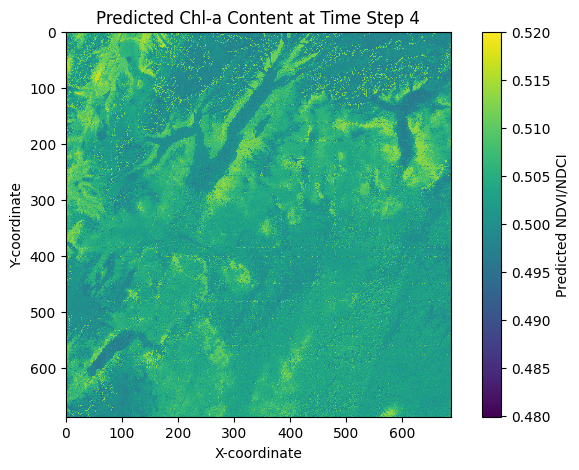

In [100]:
import numpy as np
import matplotlib.pyplot as plt

# Load the prediction data from the .npy file
y_pred_lstm_grid = np.load('predicted_ndci.npy')

# Check the shape of the loaded data (optional)
print("Shape of the loaded prediction:", y_pred_lstm_grid.shape)

# Create the plot
plt.figure(figsize=(8, 5))  # You can adjust the figure size as needed

# Visualize the data using imshow
plt.imshow(y_pred_lstm_grid, cmap='viridis', interpolation='nearest')

# Add a colorbar to show the scale
plt.colorbar(label='Predicted NDVI/NDCI')

# Set the title of the plot
plt.title("Predicted Chl-a Content at Time Step 4")

# Optionally, add axis labels (depending on the nature of your data)
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')

# Show the plot
plt.show()
